In [15]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [17]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [18]:
print(train.shape, test.shape)

(2896, 34) (1008, 33)


In [19]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')
print(train.shape, test.shape)

(2577, 34) (936, 33)


In [20]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율'],
      dtype='object')

In [21]:
train=train.drop(['subway_name', 'subway_dist', '환승역 수', '연면적','자격유형'], axis=1)
test=test.drop(['subway_name', 'subway_dist', '환승역 수', '연면적','자격유형'], axis=1)

## 상가비율, 대형전용면적, 세대당가능주차면수, 공가수, 분양세대수

In [22]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 29) (936, 28)

...After preprocessing
(2577, 34) (936, 33)


# 유림 EDA(변수) 반영

In [23]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']
test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [24]:
train=train.drop(['남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율'], axis=1)
test=test.drop(['남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세',
                  '남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율'], axis=1)       

In [25]:
def func3(x,dic):
    for i in dic.keys():
        if len(dic[i]) == len(x):
            if all(dic[i] == x):
                return i

train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

train.loc[train['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'
test.loc[test['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'

no_shop = train[train['공급유형']!='임대상가']
uniq = np.reshape(no_shop['공급유형'].unique(),(7,1))

dic = dict(enumerate(uniq))
dic[8] = ['공공임대(단기)', '국민임대']
dic[9] = ['장기전세', '국민임대', '영구/행복']
dic[10] = ['국민임대', '영구/행복']
dic[11] = ['공공임대(단기)', '공공임대(분납)']
dic[12] = ['공공분양', '공공임대(단기)', '공공임대(분납)']
dic[13] = ['공공임대(50년)', '영구/행복']
dic[14] = ['장기전세', '공공임대(단기)', '공공임대(분납)']

# dic1

dic1 = dict()
for i in dic.keys():
    val = train.loc[train['공급유형'].isin(dic[i]),'임대료'].mean()
    dic1[i] = val

# train
no_shop = train[train['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
sample['cluster'] = sample['cluster'].apply(lambda x: int(x))
train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
train['cluster'] = train['cluster'].apply(lambda x: dic1[x])
#train = train.drop(['공급유형'],axis=1)


# test
no_shop = test[test['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
test['cluster'] = test['cluster'].apply(lambda x: dic1[x])
#test = test.drop(['공급유형'],axis=1)

# 공급유형

In [26]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [27]:
train.shape, test.shape

((2577, 29), (936, 28))

# Row 별로 Y 다르게 만들기

In [28]:
train.등록차량수=(train.등록차량수/train.총세대수)*train.전용면적별세대수

In [29]:
train.단지내주차면수=(train.단지내주차면수/train.총세대수)*train.전용면적별세대수

In [30]:
test.단지내주차면수=(test.단지내주차면수/test.총세대수)*test.단지내주차면수

# Correlation 확인

In [31]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '위도', '경도', '총인구수', '세대당_인구', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적',
       '분양세대수', '0~19 인구수', '20~39 인구수', '40~69 인구수', '70세이상 인구수'],
      dtype='object')

In [32]:
test.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '지하철역', '버스정류장', '단지내주차면수', '단지명', '도로명주소', '임대보증금', '임대료', '위도', '경도',
       '총인구수', '세대당_인구', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적', '분양세대수',
       '0~19 인구수', '20~39 인구수', '40~69 인구수', '70세이상 인구수'],
      dtype='object')

In [33]:
X_cor = train.drop(columns=['단지코드','단지명','도로명주소','지역', "총세대수"])

In [34]:
X_cor = pd.get_dummies(X_cor, drop_first=True)

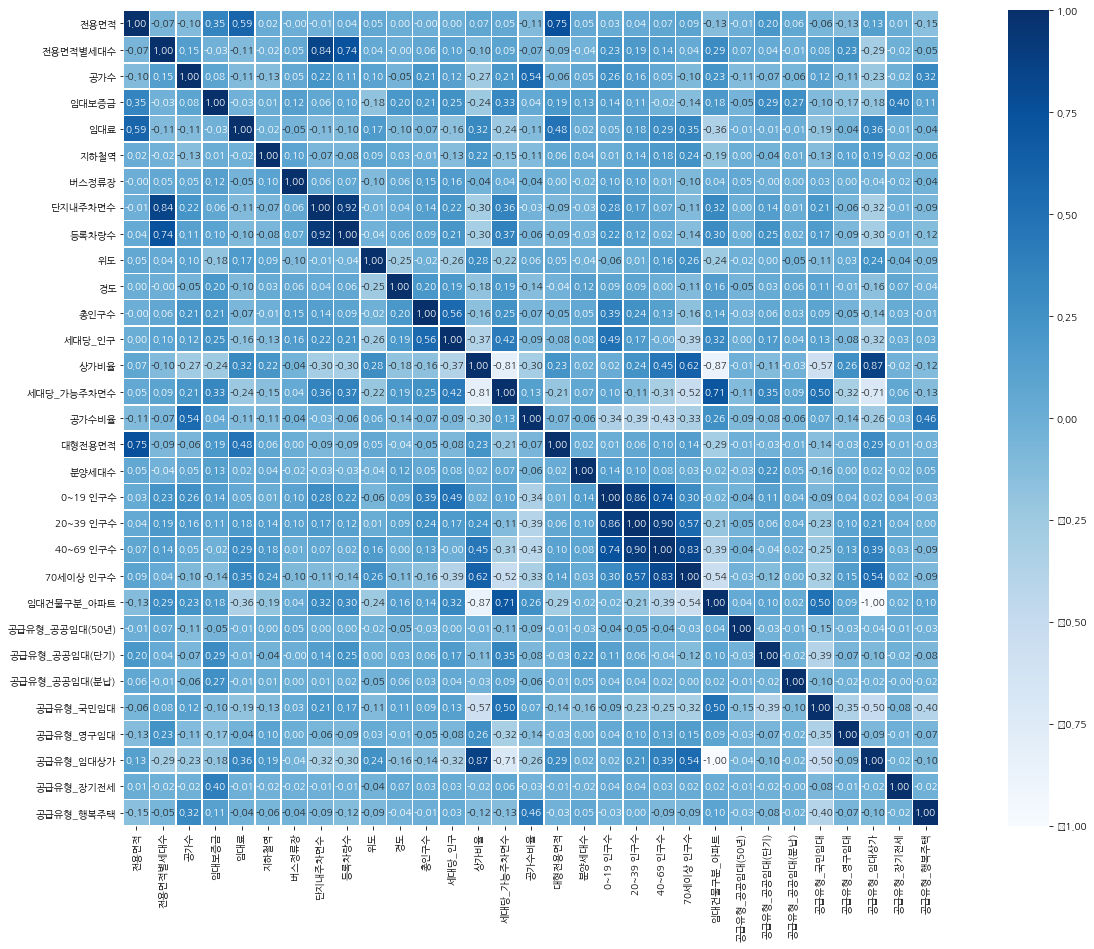

In [35]:
plt.subplots(figsize=(25,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

# Modeling

In [36]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

## 기본으로 돌려보기

In [37]:
X = train.drop(columns=['단지명','단지코드','도로명주소','등록차량수', "총세대수"])
y = train[['등록차량수']]

In [104]:
#X = pd.get_dummies(X, drop_first=True)

In [38]:
len(X.columns)

24

In [39]:
X.columns

Index(['임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '지하철역', '버스정류장', '단지내주차면수', '위도', '경도', '총인구수', '세대당_인구', '상가비율',
       '세대당_가능주차면수', '공가수비율', '대형전용면적', '분양세대수', '0~19 인구수', '20~39 인구수',
       '40~69 인구수', '70세이상 인구수'],
      dtype='object')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [41]:
X_train.shape, y_train.shape

((1803, 24), (1803, 1))

In [109]:
#import statsmodels.api as sm
#mod = sm.OLS(y_train, X_train)
#res = mod.fit()
#print(res.summary())

In [110]:
#train3=pd.read_csv("train3_유림.csv")

In [111]:
#X = train3.drop(columns=['단지코드','등록차량수'])
#y = train3[['등록차량수']]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [112]:
#mod = sm.OLS(y_train, X_train)
#res = mod.fit()
#print(res.summary())

In [113]:
lr= LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_absolute_error(y_test, lr_pred)

21.420544936632243

In [114]:
ri = Ridge().fit(X_train, y_train)
ri_pred = ri.predict(X_test)
mean_absolute_error(y_test, ri_pred)

21.37131756795474

In [115]:
la = Lasso().fit(X_train, y_train)
la_pred = la.predict(X_test)
mean_absolute_error(y_test, la_pred)

21.468864432379405

In [116]:
rf = RandomForestRegressor(random_state=2021, criterion="mae").fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mean_absolute_error(y_test, rf_pred)

16.319074215429062

In [42]:
cb = CatBoostRegressor(random_state=2021, verbose=False ).fit(X_train, y_train)
cb_pred = cb.predict(X_test)
mean_absolute_error(y_test, cb_pred)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="아파트": Cannot convert 'b'\xec\x95\x84\xed\x8c\x8c\xed\x8a\xb8'' to float

In [118]:
en=ElasticNet(random_state=2021).fit(X_train, y_train)
en_pred = en.predict(X_test)
mean_absolute_error(y_test, en_pred)

21.818794559476306

Text(0.5, 0, 'CatBoost Feature Importance')

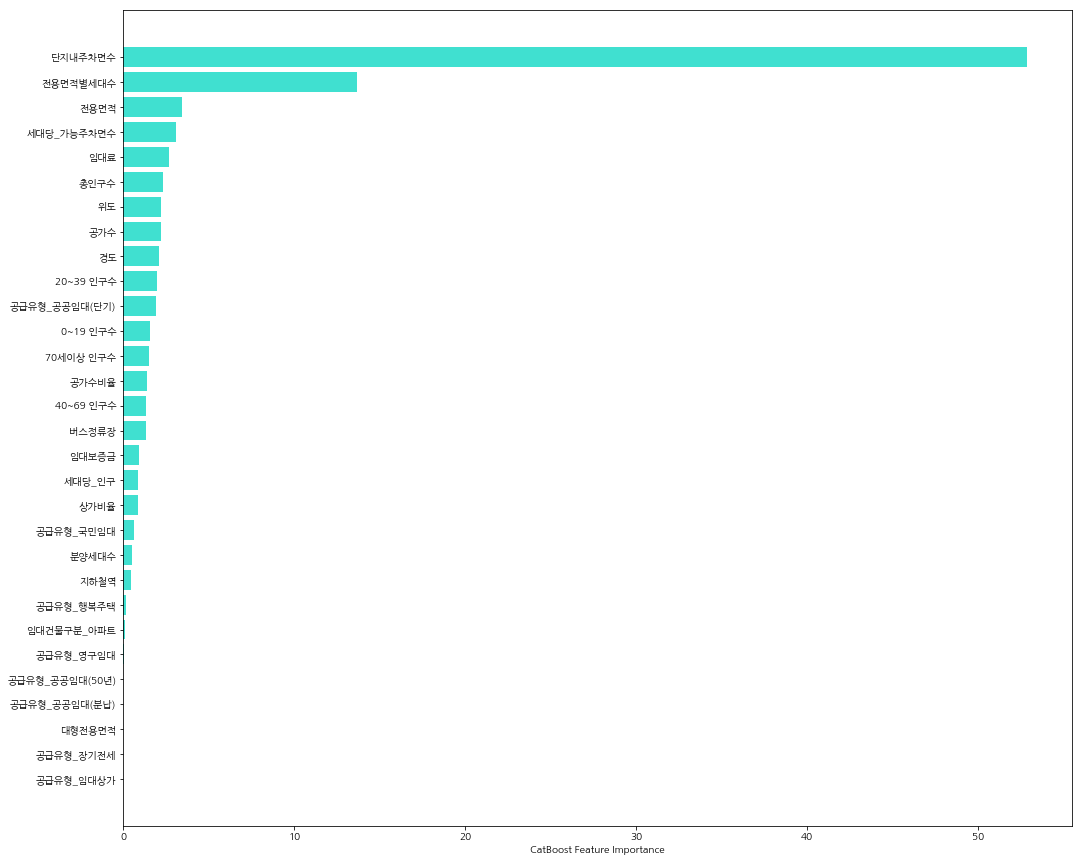

In [119]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = cb.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
        cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# 나눠서 예측

In [120]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

code  num
0  C1072    0
1  C1128    0
2  C1456    0
3  C1840    0
4  C1332    0

In [121]:
sample.shape

(150, 2)

In [122]:
df= pd.concat([train, test])

In [123]:
X = df.drop(columns=['단지명','단지코드','도로명주소','등록차량수', "지역", "총세대수"])
X = pd.get_dummies(X, drop_first=True)

In [124]:
X.columns

Index(['전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수',
       '위도', '경도', '총인구수', '세대당_인구', '상가비율', '세대당_가능주차면수', '공가수비율', '대형전용면적',
       '분양세대수', '0~19 인구수', '20~39 인구수', '40~69 인구수', '70세이상 인구수',
       '임대건물구분_아파트', '공급유형_공공임대(50년)', '공급유형_공공임대(단기)', '공급유형_공공임대(분납)',
       '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가', '공급유형_장기전세', '공급유형_행복주택'],
      dtype='object')

In [125]:
len(X.columns)

30

In [126]:
train.shape, test.shape

((2577, 29), (936, 28))

In [127]:
X_train=X.iloc[0:2577, :]
X_test=X.iloc[2577:, :]
y_train = train[['등록차량수']]

In [128]:
#X.test["장기전세"]=0
#X.test["공공분양"]=0

In [129]:
model_1=CatBoostRegressor(random_state=2021, verbose=False).fit(X_train, y_train)
model1_pred = model_1.predict(X_test)

In [130]:
model1=pd.DataFrame(model1_pred)
code1=test.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [131]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1=pred1.num.groupby(pred1.code).sum()
pred1.head()

code
C1003    1019.883815
C1006    1112.106847
C1016    1744.171388
C1019     674.438759
C1030      42.468436
Name: num, dtype: float64

In [132]:
pred1=pd.DataFrame(pred1)

In [133]:
test_split=pd.merge(sample, pred1, on='code', how='outer')

In [134]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [135]:
test_split[test_split.num<=0].index

Int64Index([], dtype='int64')

In [136]:
from catboost import Pool

In [137]:
sorted_feature_importance = model_1.feature_importances_.argsort()

In [138]:
sorted_feature_importance

array([15, 28, 27, 24, 22, 26, 21, 29,  5, 16,  3, 25, 19, 17,  6, 12, 11,
       18, 23, 10, 20, 14,  9,  8,  4,  2, 13,  0,  1,  7], dtype=int64)

In [139]:
X_test.columns[sorted_feature_importance]

Index(['대형전용면적', '공급유형_장기전세', '공급유형_임대상가', '공급유형_공공임대(분납)', '공급유형_공공임대(50년)',
       '공급유형_영구임대', '임대건물구분_아파트', '공급유형_행복주택', '지하철역', '분양세대수', '임대보증금',
       '공급유형_국민임대', '40~69 인구수', '0~19 인구수', '버스정류장', '상가비율', '세대당_인구',
       '20~39 인구수', '공급유형_공공임대(단기)', '총인구수', '70세이상 인구수', '공가수비율', '경도', '위도',
       '임대료', '공가수', '세대당_가능주차면수', '전용면적', '전용면적별세대수', '단지내주차면수'],
      dtype='object')

Text(0.5, 0, 'CatBoost Feature Importance')

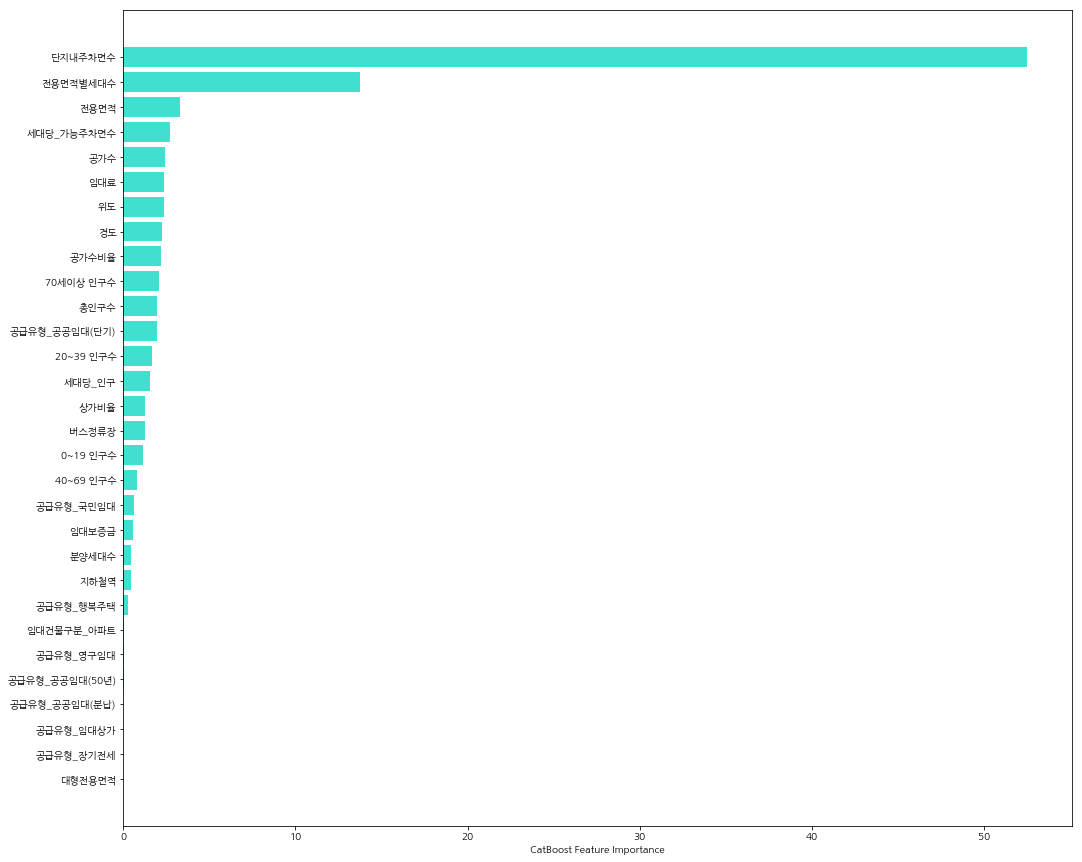

In [140]:
plt.subplots(figsize=(17,15))
sorted_feature_importance = model_1.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_feature_importance], 
        model_1.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [141]:
one=pd.read_csv("0713_cb.csv")

In [142]:
one = one.loc[~one.code.isin(['C2335', 'C1327', 'C2675'])]

In [143]:
test_= test_split.loc[~test_split.code.isin(['C2335', 'C1327', 'C2675'])]

In [144]:
mean_absolute_error(one.num, test_.num)

1114.8405285202098